In [ ]:
### General Libraries
!pip install -q regex tqdm
!pip install -q diffusers transformers accelerate scipy
!pip install -q -U xformers
!pip install -q opencv-python


In [ ]:
### Sam libraries
!pip install -q git+https://github.com/facebookresearch/segment-anything.git
!pip install -q pycocotools matplotlib onnxruntime onnx

  Preparing metadata (setup.py) ... done
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 324, in run
    session = self.get_default_session(options)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 98, in get_default_session
    self._session = self.enter_context(self._build_session(options))
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 125, in _build_session
    session = PipSession(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/network/session.py", line 342, in __init__
    self.headers["User-Agent"] = user_agent()
  File "/usr/loc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
### Import libraries
import torch
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image, to_tensor

import PIL, cv2
from PIL import Image

from io import BytesIO
from IPython.display import display
import base64, json, requests
from matplotlib import pyplot as plt

import numpy as np
import copy

from numpy import asarray

import sys

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor



In [ ]:
### import Stable Diffusion model
from diffusers import StableDiffusionInpaintPipeline, EulerDiscreteScheduler

model_dir="stabilityai/stable-diffusion-2-inpainting"

### The scheduler determine the algorithm used to produce new samples during the denoising process
scheduler = EulerDiscreteScheduler.from_pretrained(model_dir, subfolder="scheduler")

pipe = StableDiffusionInpaintPipeline.from_pretrained(model_dir,
                                                   scheduler=scheduler,
                                                   revision="fp16",
                                                   torch_dtype=torch.float16)
pipe = pipe.to("cuda")
pipe.enable_xformers_memory_efficient_attention()

### if you receive a triton error message, that's normal on windows systems


/usr/local/lib/python3.10/dist-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.w

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [ ]:
from tqdm import tqdm
import os
path = '/content/drive/MyDrive/Colab Notebooks/Train'
tiles = {}
shit = 0
for tile in tqdm(os.listdir(path)):
    # if shit == 20:
    #   break
    DNB_files = []
    L2A_files = []
    LC08_files = []
    S1A_files = []
    gt_files = []
    for file in os.listdir(os.path.join(path,tile)):
        if file.startswith("DNB"):
            DNB_files.append(file)
        elif file.startswith("L2A"):
            L2A_files.append(file)
        elif file.startswith("LC08"):
            LC08_files.append(file)
        elif file.startswith("S1A"):
            S1A_files.append(file)
        else:
            gt_files.append(file)
    DNB_files.sort()
    L2A_files.sort()
    LC08_files.sort()
    S1A_files.sort()
    gt_files.sort()
    # for i in range(len(DNB_files)):
    #     img = cv2.imread(os.path.join(path, tile, DNB_files[i]),cv2.IMREAD_UNCHANGED)
    #     img = (img - np.min(img)) / (np.max(img) - np.min(img))
    #     DNB_files[i] = img
    # for i in range(len(L2A_files)):
    #     img = cv2.imread(os.path.join(path, tile, L2A_files[i]),cv2.IMREAD_UNCHANGED)
    #     img = (img - np.min(img)) / (np.max(img) - np.min(img))
    #     L2A_files[i] = img
    # for i in range(len(LC08_files)):
    #     img = cv2.imread(os.path.join(path, tile, LC08_files[i]),cv2.IMREAD_UNCHANGED)
    #     img = (img - np.min(img)) / (np.max(img) - np.min(img))
    #     LC08_files[i] = img
    # for i in range(len(S1A_files)):
    #     img = cv2.imread(os.path.join(path, tile, S1A_files[i]),cv2.IMREAD_UNCHANGED)
    #     img = (img - np.min(img)) / (np.max(img) - np.min(img))
    #     S1A_files[i] = img
    # for i in range(len(gt_files)):
    #     img = cv2.imread(os.path.join(path, tile, gt_files[i]),cv2.IMREAD_UNCHANGED)
    #     img = (img - np.min(img)) / (np.max(img) - np.min(img))
    #     gt_files[i] = img
    file_dict = {
        # "DNB":DNB_files,
        "L2A": L2A_files,
        "LC08": LC08_files,
        # "S1A" : S1A_files,
        # "GT": gt_files
    }
    tiles[tile] = file_dict
    print(tile)
    shit += 1

 12%|█▏        | 7/60 [00:00<00:00, 64.08it/s]

Tile42
Tile26
Tile58
Tile33
Tile55
Tile59
Tile32
Tile29
Tile36
Tile39
Tile50
Tile48
Tile31


 35%|███▌      | 21/60 [00:00<00:00, 57.74it/s]

Tile35
Tile54
Tile53
Tile37
Tile49
Tile46
Tile27
Tile52
Tile41
Tile44
Tile34
Tile57


 55%|█████▌    | 33/60 [00:00<00:00, 57.18it/s]

Tile28
Tile47
Tile43
Tile60
Tile45
Tile38
Tile51
Tile56
Tile30
Tile40
Tile1
Tile2
Tile3


 82%|████████▏ | 49/60 [00:00<00:00, 66.52it/s]

Tile4
Tile5
Tile6
Tile7
Tile8
Tile9
Tile10
Tile11
Tile12
Tile13
Tile14
Tile15
Tile16
Tile17
Tile18
Tile19


100%|██████████| 60/60 [00:00<00:00, 66.09it/s]

Tile20
Tile21
Tile22
Tile23
Tile24
Tile25


In [ ]:
def make_image(tile):
  imgs = []
  for i in range(5, 2, -1):
    img = cv2.imread(os.path.join(path, tile, LC08_files[i]),cv2.IMREAD_UNCHANGED)
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    imgs.append(img)
    # print(path + "/" + tile + LC08_files[i])
  img = np.stack(imgs, axis=2)
  # plt.imshow(img)
  return img

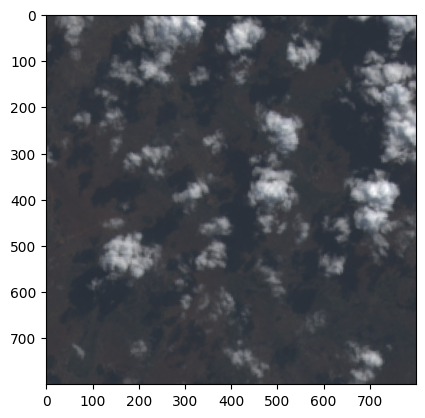

In [ ]:
img = make_image("Tile49")
plt.imshow(img)

Target image size: 786432


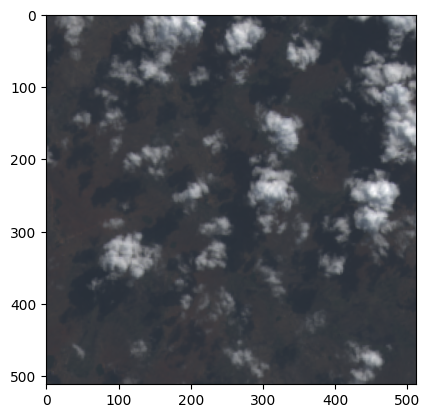

In [ ]:
target_width, target_height = 512,512 # if you have memory issues, reduce even more the target size
source_image = img

# We make the image square
# source_image = source_image.crop((0, height-width , width , height))  # box=(left, upper, right, lower)

# We resize the image to the target dimensions (so that it uses less memory)
source_image = cv2.resize(source_image, (target_width, target_height), interpolation=cv2.INTER_AREA)
print(f"Target image size: {source_image.size}")

### we convert the image into an array in order to use it later with the segmentation model
segmentation_image = asarray(source_image)

plt.imshow(source_image)

In [ ]:
### Initialize Segment Anything Model

sam_checkpoint = "/content/drive/MyDrive/Colab Notebooks/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

### Pay attention to the pred_iou_thresh, the lower the more masks it will generate. Make it higher to generate masks only of
### good quality and less number of them
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.95, # A filtering threshold in [0,1], using the model's predicted mask quality.
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [ ]:
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.92, # A filtering threshold in [0,1], using the model's predicted mask quality.
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [ ]:
### Run Segmentation Model
masks = mask_generator.generate(segmentation_image)

### Print number of masks generated and the keys attached to each of them
print(f"Number of masks generated: {len(masks)}")
print(masks[0].keys())

# Intersection Over Union (IoU) tell us the degree of overlap between two boxes.
# In the case of object detection and segmentation, it refers to the overlap of the Ground Truth and Prediction region

Number of masks generated: 107
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [ ]:
bg = 0
bg_size = 0
for i, values in enumerate(masks):
   if values['area'] > bg_size:
    bg_size = values['area']
    bg = i
   print(f"{i}: Area: {values['area']} | IoU: {values['predicted_iou']}")
print(bg)

0: Area: 2094 | IoU: 1.008899211883545
1: Area: 8180 | IoU: 0.9995858669281006
2: Area: 908 | IoU: 0.9764798879623413
3: Area: 1935 | IoU: 0.9757071733474731
4: Area: 546 | IoU: 0.9750185012817383
5: Area: 1177 | IoU: 0.973751962184906
6: Area: 712 | IoU: 0.9737242460250854
7: Area: 237 | IoU: 0.9657312631607056
8: Area: 659 | IoU: 0.9641740322113037
9: Area: 157 | IoU: 0.9630900621414185
10: Area: 374 | IoU: 0.9628604650497437
11: Area: 1251 | IoU: 0.9623578786849976
12: Area: 392 | IoU: 0.9602057933807373
13: Area: 123 | IoU: 0.959254264831543
14: Area: 223 | IoU: 0.9587533473968506
15: Area: 185 | IoU: 0.9564748406410217
16: Area: 426 | IoU: 0.9553188681602478
17: Area: 324 | IoU: 0.954591691493988
18: Area: 861 | IoU: 0.9543604850769043
19: Area: 514 | IoU: 0.947003185749054
20: Area: 899 | IoU: 0.9426565170288086
21: Area: 386 | IoU: 0.9390901327133179
22: Area: 1117 | IoU: 0.936798632144928
23: Area: 274 | IoU: 0.9352279305458069
24: Area: 136 | IoU: 0.9340986013412476
25: Area: 

In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return

    # Sort masks by area in descending order
    sorted_anns = sorted(enumerate(anns), key=(lambda x: x[1]['area']), reverse=True)
    ax = plt.gca()

    # Disable autoscale to keep the image size consistent
    ax.set_autoscale_on(False)

    # Iterate through each mask and display it on top of the original image
    for original_idx, ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))

        # Generate a random color for the mask
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]

        # Blend the mask with the image, using 0.35 as the alpha value for transparency
        ax.imshow(np.dstack((img, m*0.35)))

        # Find contours of the mask to compute the centroid
        contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            cnt = contours[0]
            M = cv2.moments(cnt)

            # Compute the centroid of the mask if the moment is non-zero
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])

                # Display the original index number (1-based) at the centroid of the mask
                # The text is white, bold, and has a font size of 16
                ax.text(cx, cy, str(original_idx), color='white', fontsize=16, ha='center', va='center', fontweight='bold')

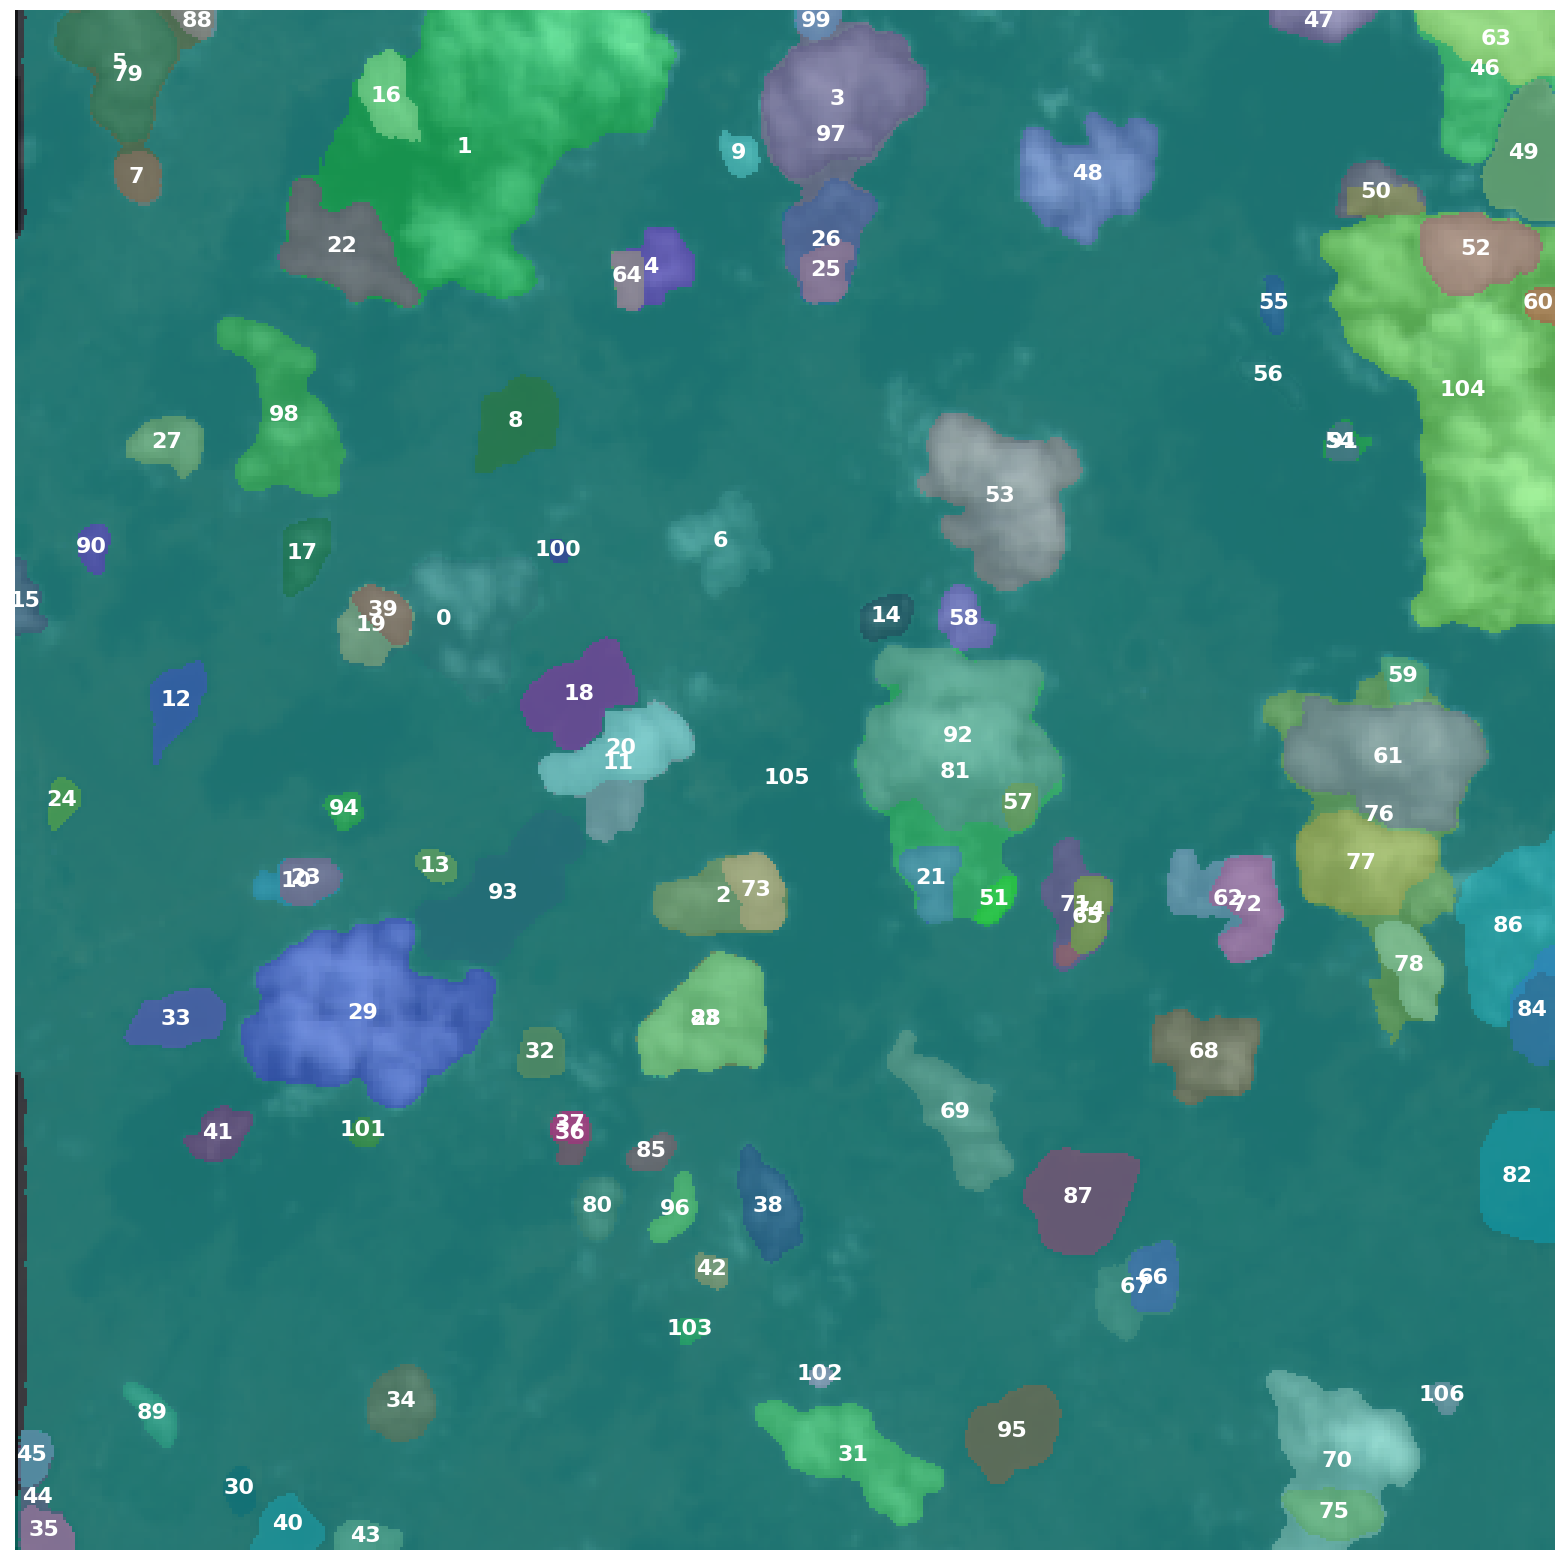

In [ ]:
### Display Masks with a number identifying each of them

plt.figure(figsize=(20,20))
plt.imshow(source_image)
show_anns(masks)  # use masks[:-x] to only display the first masks of the list
plt.axis('off')
plt.show()

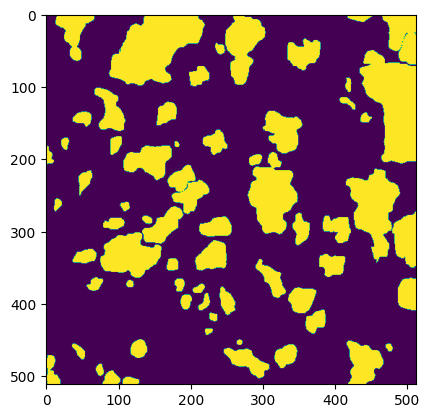

In [ ]:
# Decide which mask you want to do inpainting with. In this case we pick the skirt which is mask number 4

segmentation_mask = np.zeros([512,512])
for i in range(105):
    segmentation_mask += masks[i]['segmentation']
segmentation_mask += masks[106]['segmentation']
# segmentation_mask=masks[mask_index]['segmentation']
# stable_diffusion_mask=PIL.Image.fromarray(segmentation_mask)
stable_diffusion_mask = segmentation_mask.astype(np.uint8)
stable_diffusion_mask[stable_diffusion_mask >= 1] = 1

# display(stable_diffusion_mask)
plt.imshow(stable_diffusion_mask)



In [ ]:
### Setup transformation prompts
num_images_per_prompt = 4
# inpainting_prompts = ["",  "", "", ""]
inpainting_prompts = ["landscape"]
generator = torch.Generator(device="cuda").manual_seed(77) # 155, 77,

### Run Stable Difussion pipeline in inpainting mode
encoded_images = []
for i in range(len(inpainting_prompts)):
        image = pipe(prompt=inpainting_prompts[i], guidance_scale=7.5, num_inference_steps=60, generator=generator, image=source_image, mask_image=stable_diffusion_mask).images[0]
        encoded_images.append(image)

  0%|          | 0/60 [00:00<?, ?it/s]

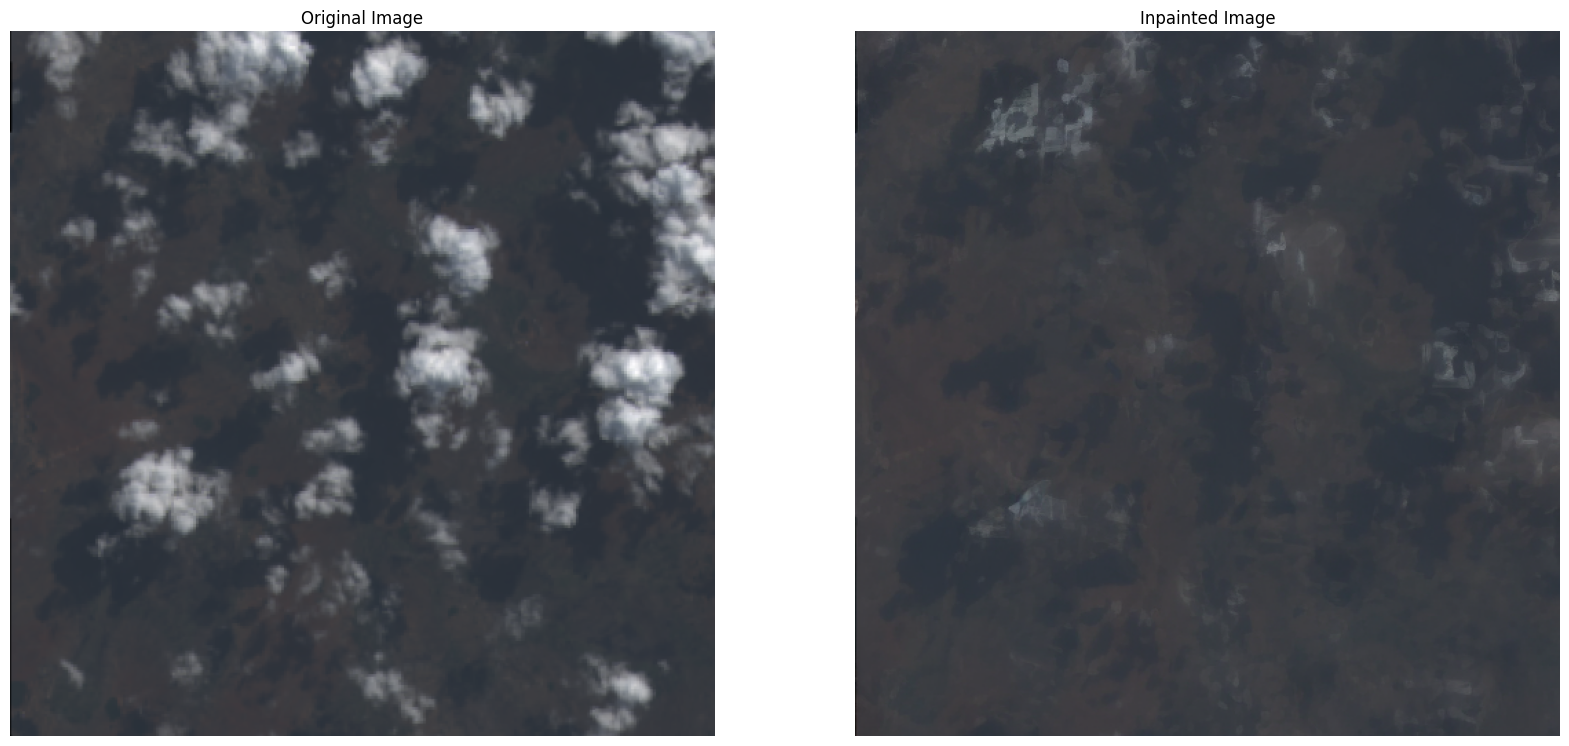

In [ ]:

def show_single_image(image, name=""):
    # Check if the image is a tensor
    if torch.is_tensor(image):
        # Convert tensor image to PIL image and apply sigmoid normalization
        image = to_pil_image(torch.sigmoid(image))

    # Create a figure
    fig, ax = plt.subplots(1, 2, figsize=(20, 15))
    ax[0].imshow(source_image)
    ax[0].axis('off')
    ax[0].set_title("Original Image")
    # Add the image to the subplot
    ax[1].imshow(image, cmap='gray' if torch.is_tensor(image) else None)

    # Set the title (name) for the subplot
    ax[1].set_title(name)

    # Turn off axes for the subplot
    ax[1].axis('off')


    # Display the image
    plt.show()

show_single_image(encoded_images[0], "Inpainted Image")

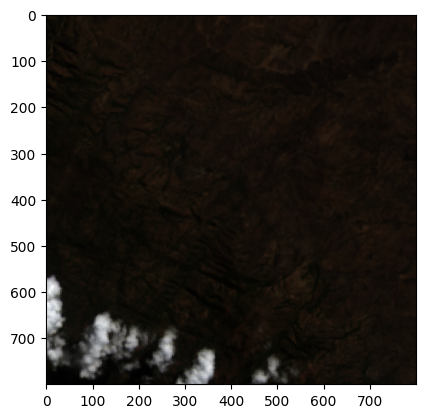

In [ ]:
img = make_image("Tile30")
plt.imshow(img)

Target image size: 786432


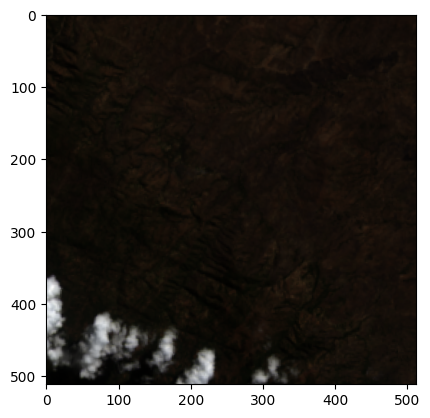

In [ ]:
target_width, target_height = 512,512 # if you have memory issues, reduce even more the target size
source_image = img

# We make the image square
# source_image = source_image.crop((0, height-width , width , height))  # box=(left, upper, right, lower)

# We resize the image to the target dimensions (so that it uses less memory)
source_image = cv2.resize(source_image, (target_width, target_height), interpolation=cv2.INTER_AREA)
print(f"Target image size: {source_image.size}")

### we convert the image into an array in order to use it later with the segmentation model
segmentation_image = asarray(source_image)

plt.imshow(source_image)

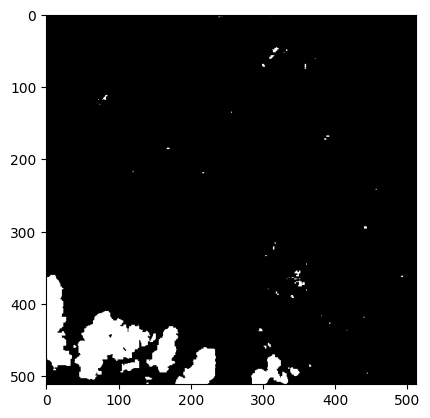

In [ ]:
# mask = cv2.threshold(, 0.5, 1, cv2.THRESH_BINARY)
# print(mask.shape)
gray = cv2.cvtColor(source_image,  cv2.COLOR_BGR2GRAY)
mask = cv2.threshold(gray, 0.10, 1, cv2.THRESH_BINARY)[1].astype("uint8")
plt.imshow(mask, cmap="gray")

## SAM

In [ ]:
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.96, # A filtering threshold in [0,1], using the model's predicted mask quality.
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [ ]:
### Run Segmentation Model
masks = mask_generator.generate(segmentation_image)

### Print number of masks generated and the keys attached to each of them
print(f"Number of masks generated: {len(masks)}")
print(masks[0].keys())

# Intersection Over Union (IoU) tell us the degree of overlap between two boxes.
# In the case of object detection and segmentation, it refers to the overlap of the Ground Truth and Prediction region

Number of masks generated: 8
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


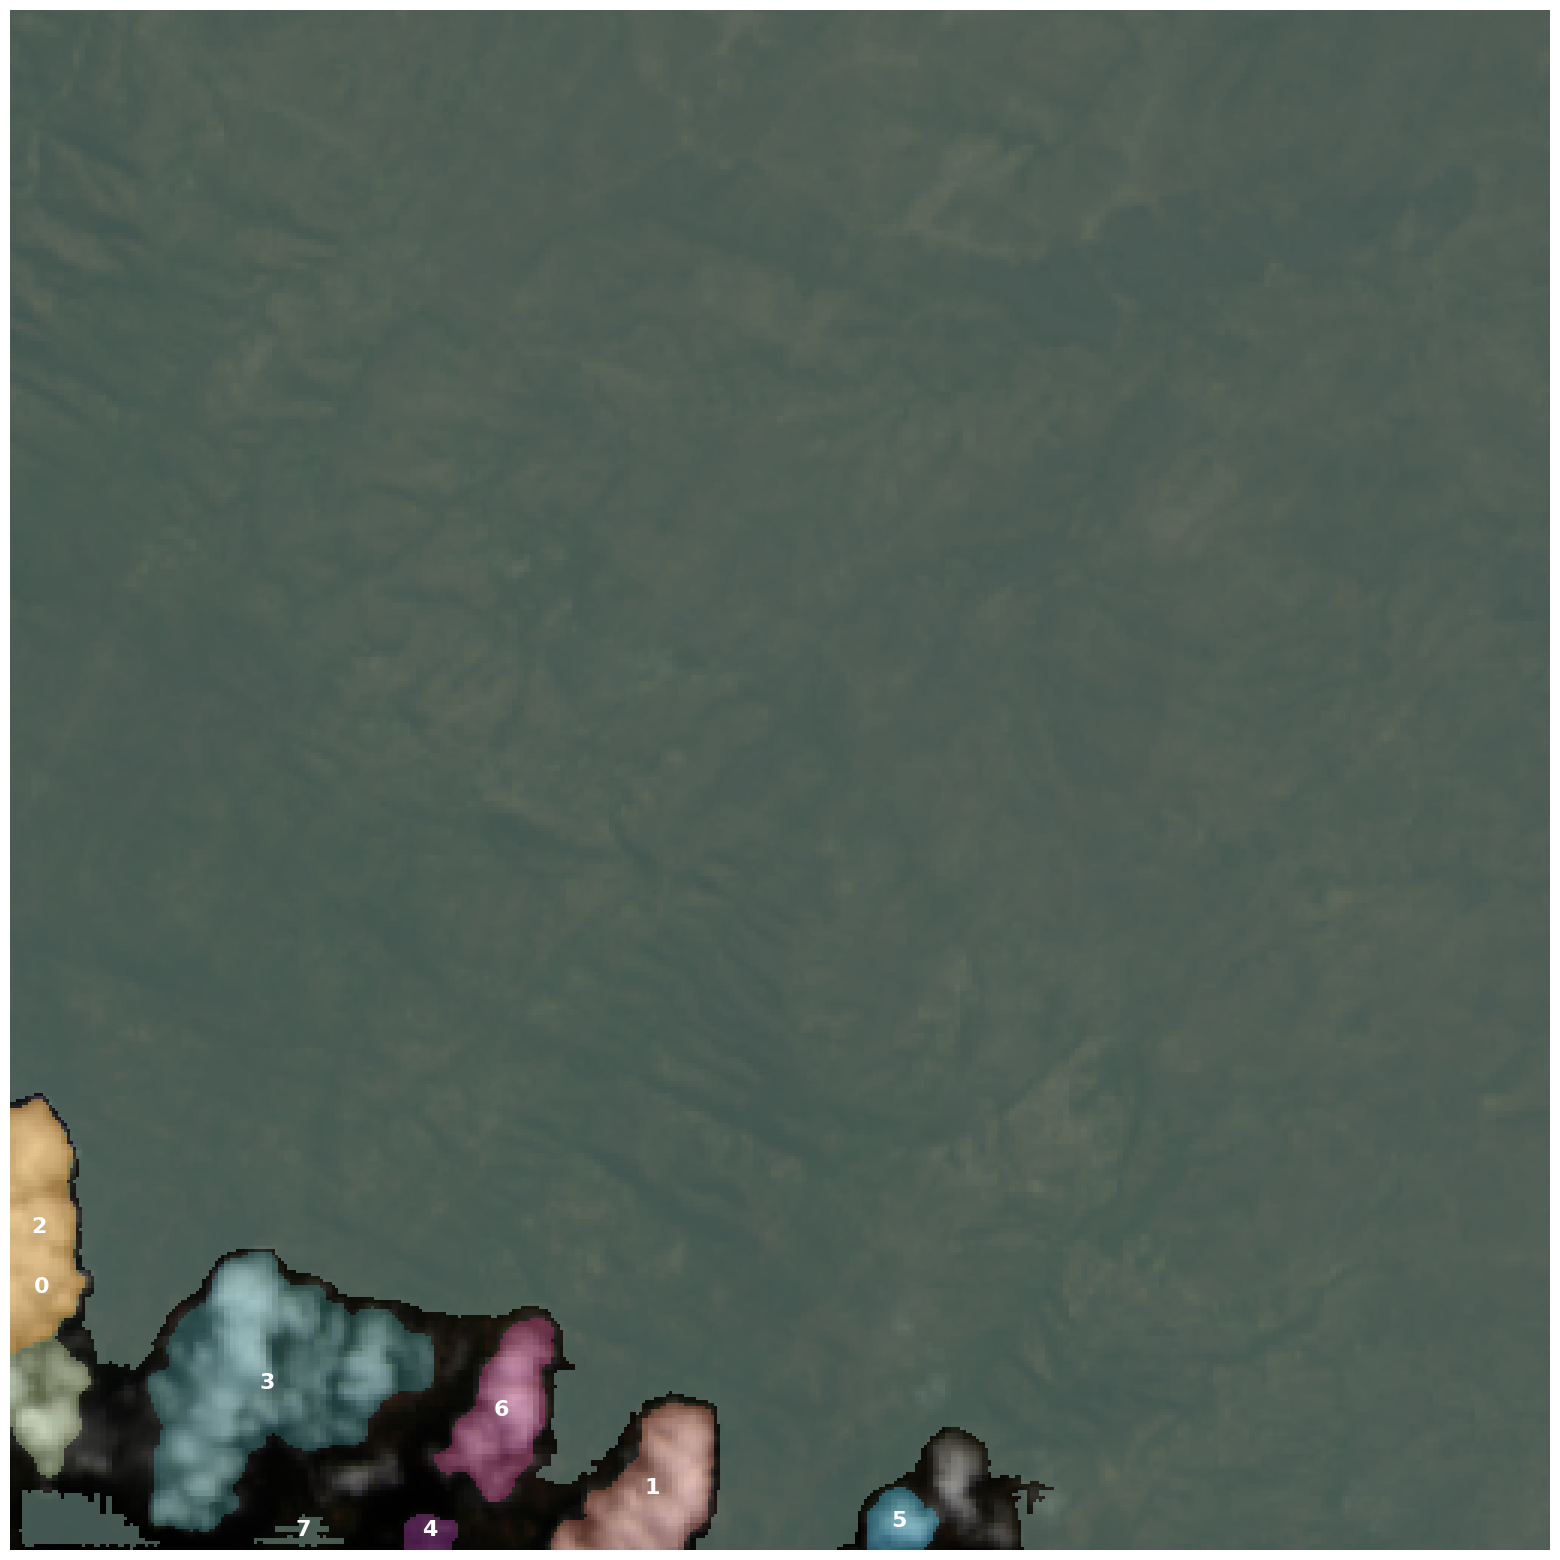

In [ ]:
### Display Masks with a number identifying each of them

plt.figure(figsize=(20,20))
plt.imshow(source_image)
show_anns(masks)  # use masks[:-x] to only display the first masks of the list
plt.axis('off')
plt.show()

In [ ]:
bg = 0
bg_size = 0
for i, values in enumerate(masks):
   if values['area'] > bg_size:
    bg_size = values['area']
    bg = i
   print(f"{i}: Area: {values['area']} | IoU: {values['predicted_iou']}")
print(bg)

0: Area: 2493 | IoU: 0.9858889579772949
1: Area: 1590 | IoU: 0.9786950349807739
2: Area: 1592 | IoU: 0.9739195704460144
3: Area: 4900 | IoU: 0.9694000482559204
4: Area: 187 | IoU: 0.967125654220581
5: Area: 395 | IoU: 0.9719162583351135
6: Area: 1300 | IoU: 0.9691506624221802
7: Area: 242644 | IoU: 1.0349053144454956
7


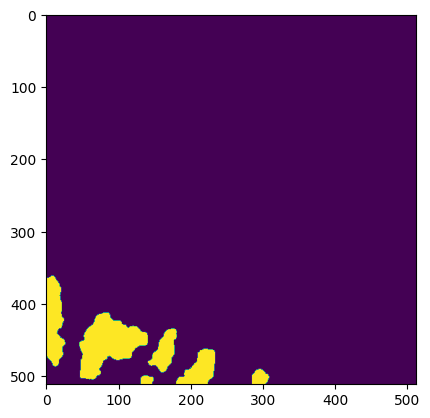

In [ ]:
# Decide which mask you want to do inpainting with. In this case we pick the skirt which is mask number 4

segmentation_mask = np.zeros([512,512])
for i in range(7):
    segmentation_mask += masks[i]['segmentation']
# segmentation_mask += masks[106]['segmentation']
# segmentation_mask=masks[mask_index]['segmentation']
# stable_diffusion_mask=PIL.Image.fromarray(segmentation_mask)
stable_diffusion_mask = segmentation_mask.astype(np.uint8)
stable_diffusion_mask[stable_diffusion_mask >= 1] = 1

# display(stable_diffusion_mask)
plt.imshow(stable_diffusion_mask)



## diffusion model

In [ ]:
inpainting_prompts = ["landscape"]
generator = torch.Generator(device="cuda").manual_seed(77) # 155, 77,

### Run Stable Difussion pipeline in inpainting mode
encoded_images = []
for i in range(len(inpainting_prompts)):
        image = pipe(prompt=inpainting_prompts[i], guidance_scale=7.5, num_inference_steps=60, generator=generator, image=source_image, mask_image=mask).images[0]
        encoded_images.append(image)

  0%|          | 0/60 [00:00<?, ?it/s]

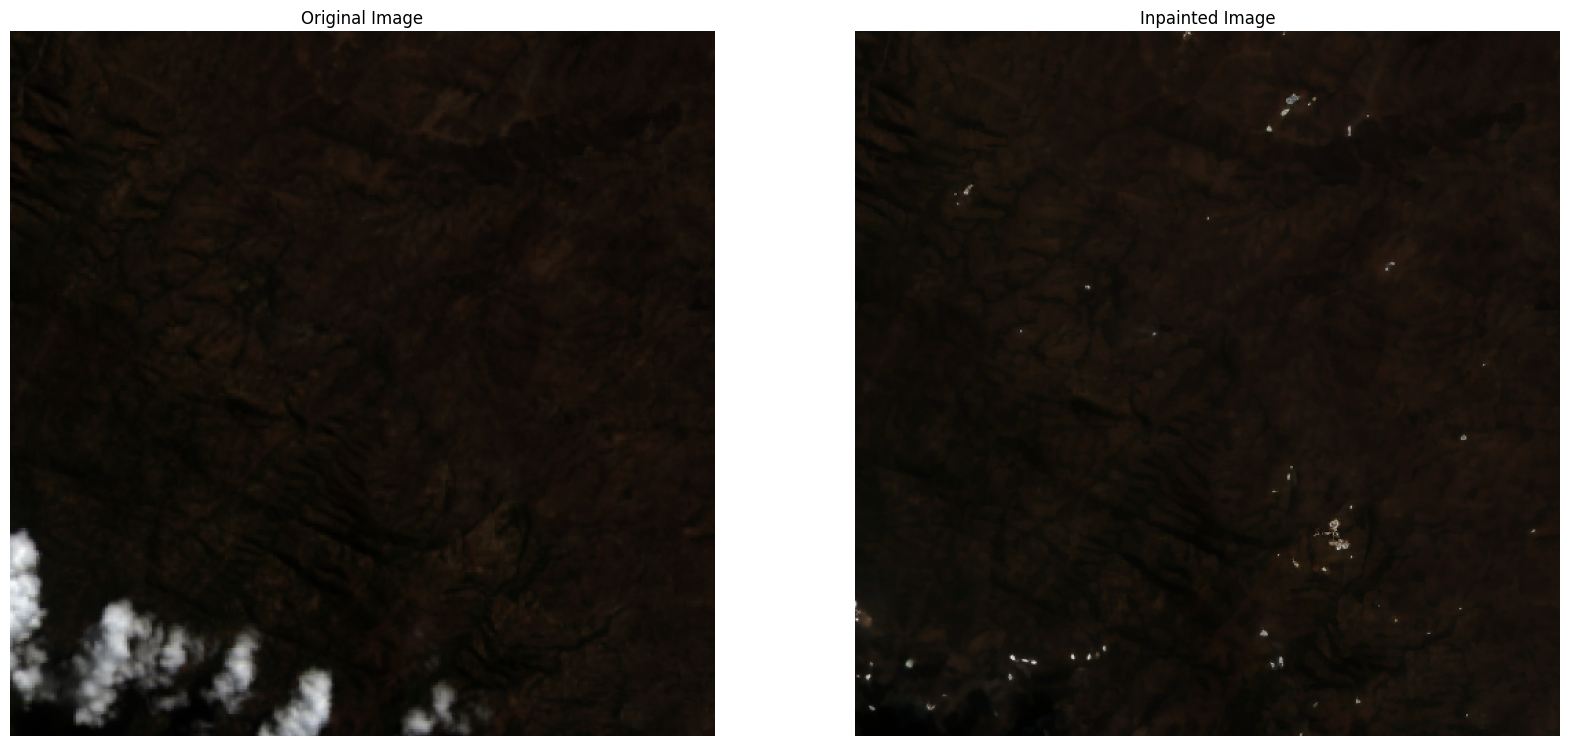

In [ ]:
show_single_image(encoded_images[0], "Inpainted Image")